# Data analysis and XGBoost model 

This notebook aims to explore the distribution of the dataset and to perform a first analysis of the data. It also intends to train an XGBoost model using the tf-Idf embedding with and without oversampling.

In [15]:
#Essential modules
import pandas as pd
import numpy as np

#For text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#For model-building
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

#To vectorize our textual data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
#Import dataset of live commentaries scraped from live score websites such as bbc.com, espn.com, ...
df = pd.read_csv("events.csv")
#Drop unnecessary columns for our study
to_drop = ['sort_order', 'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break']
df.drop(to_drop, axis=1, inplace=True)
df.head(5)

,id_odsp,id_event,time,text,event_type,event_type2,side,event_team,opponent,player,player2
0,UFot0hit/,UFot0hit1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore
1,UFot0hit/,UFot0hit2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier
2,UFot0hit/,UFot0hit3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann
3,UFot0hit/,UFot0hit4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN
4,UFot0hit/,UFot0hit5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN


In [3]:
#Storing the clubs of different leagues to count the number of games of each league 

bundesliga_abb = {'BIE' : 'Arminia Bielefeld','LEV':'Bayer Leverkusen',"LEV":"Leverkusen","LEV":'Leverkusen','BAY':'Bayern Munich','DOR':'Borussia Dortmund',
                'MGB':'Borussia Moenchengladbach',
                'CGN':'FC Cologne','SGE':'Eintracht Frankfurt',"SGE":'Eint Frankfurt',"SGE":'Eint Frankfurt','AUG':'FC Augsburg','SCF':'Freiburg','BCS':'Hertha Berlin',
                'TSG':'Hoffenheim','M05':'Mainz 05','RBL':'RB Leipzig','S04':'Schalke 04','FCU':'Union Berlin',
                'STU':'VfB Stuttgart','WOB' :'VfL Wolfsburg','SVW':'Werder Bremen',"KOE":"Koln","KOE":"Köln","KOE":"Koeln","KOE":"Köln"}

ligue1_abb ={'ANR':'Angers','BOR':'Bordeaux','BOR':'Bordeaux','BRS':'Brest','DIJ':'Dijon','LIL':'Lille','LOR':'Lorient',
            'LOR':'Lorient','MTZ':'Metz','MET':'Metz','NIC':'Nice',
            'MCO':'Monaco','MTP':'Montpellier',
            'NAN':'Nantes','NIC':'Nice','NMS':'Nimes','LYO':'Olympique Lyon','OL':'Olympique Lyon','OL':'Lyon',
            'MAR':'Olympique Marseille','MAR':'Olympique Marseille','PSG':'Paris St Germain',
            'LEN':'RC Lens','REI':'Reims','REN':'Rennes','REI':'Reims',
            'STE':'Saint-Etienne','STE':'Saint-Etienne','SBG':'Strasbourg'}

laliga_abb = {'ALV':'Alaves','ATH':'Athletic Bilbao',"ATH":"Athletic Club",'ATB':'Athletic Bilbao','BAR':'Barcelona',
            'ATL':'Atletico Madrid','BAR':'Barcelona','CCF':'Cadiz','CAD':'Cadiz','CLV':'Celta Vigo',
            'CEL':'Celta Vigo','EIB':'Eibar','ECF':'Elche','GTF':'Getafe','GRA':'Granada','HUE':'Huesca (ESP)',
            'LUD':'Levante','OSA':'Osasuna','BET':'Real Betis','MAD':'Real Madrid','RSO':'Real Sociedad',
            'VLL':'Real Valladolid','SFC':'Sevilla',
            'VCF':'Valencia','VIL':'Villarreal'}

seriea_abb = {'ACM':'AC Milan','ROM':'AS Roma','ATT':'Atalanta','ATA':'Atalanta',
            'BNV':'Benevento','BGN':'Bologna','BOL':'Bologna','CAG':'Cagliari',
            'CRT':'Crotone','FIO':'Fiorentina','GEN':'Genoa','HEL':'Hellas Verona','VER':'Verona','VER':'Hellas Verona',
            'INT':'Inter Milan','JUV':'Juventus',
            'LAZ':'Lazio','NAP':'Napoli','PMA':'Parma',
            'SAM':'Sampdoria','SASS':'Sassuolo','SPZ':'Spezia Calcio',
            'TNO':'Torino','UDI':'Udinese'}
premier_league = {'Arsenal': 'ARS',
                'Aston Villa': 'AVL',
                'Brighton': 'BHA',
                'Burnley': 'BRN',
                'Chelsea': 'CHE',
                'Crystal Palace': 'CRY',
                'Everton': 'EVE',
                'Fulham': 'FUL',
                'Leeds Utd': 'LEE',
                'Leicester City': 'LEI',
                'Liverpool': 'LIV',
                'Manchester City': 'MCI',
                'Manchester Utd': 'MU',
                'Newcastle Utd': 'NEW',
                'Sheffield Utd': 'SHU',
                'Southampton': 'SOU',
                'Tottenham Hotspur': 'TOT',
                'West Bromwich Albion': 'WBA',
                'West Ham Utd': 'WHU',
                'Wolverhampton Wanderers': 'WOL',
                'Tottenham': 'TOT',
                'Wolves': 'WOL',
                'West Ham': 'WHU',
                'West Brom': 'WBA',
                'Leeds': 'LEE',
                'West Ham United': 'WHU',
                'Manchester United': 'MU'}


ligue1_clubs = list(ligue1_abb.values())
ligue1_clubs.extend(['Valenciennes', 'Caen', 'Evian Thonon Gaillard', 'Brest', 
                    'AC Ajaccio','Toulouse', 'AS Nancy Lorraine', 'AJ Auxerre', 
                    'Sochaux', 'Stade Rennes', 'Dijon FCO', 'Bastia','AS Monaco', 
                    'Guingamp', 'Nantes',  'Metz', 'Lens', 'Angers', 'GFC Ajaccio', 
                    'Paris Saint-Germain', 'Marseille', 'St Etienne', 'Stade de Reims',
                    'Troyes'])
liga_clubs = list(laliga_abb.values())
liga_clubs.extend(['Sporting Gijon', 'Real Sociedad',
                    'Valencia', 'Racing Santander', 'Real Madrid', 'Real Zaragoza',
                    'Sevilla', 'Malaga', 'Rayo Vallecano', 'Athletic Bilbao', 'Getafe',
                    'Levante', 'Osasuna', 'Atletico Madrid', 'Espanyol', 'Mallorca',
                    'Villarreal', 'Barcelona', 'Deportivo La Coruna', 'Real Valladolid',
                    'Almeria', 'Elche', 'Eibar', 'Cordoba', 'Las Palmas', 'Alaves','Leganes'])
bundesliga_clubs = list(bundesliga_abb.values())
bundesliga_clubs.extend(['Hamburg SV', 'Borussia Dortmund', 'FC Augsburg', 'SC Freiburg',
                        'Werder Bremen', 'Kaiserslautern','Nurnberg', 'Hannover 96', 
                        'TSG Hoffenheim', 'Mainz', 'Borussia Monchengladbach','SpVgg Greuther Furth', 
                        'Fortuna Dusseldorf','Eintracht Frankfurt', 'TSV Eintracht Braunschweig',
                        'SC Paderborn', 'SV Darmstadt 98', 'FC Ingolstadt 04', "Bayer Leverkusen"])
premierleague_clubs = list(premier_league.values())
premierleague_clubs.extend(['Aston Villa', 'Hull', 'Fulham',
                            'Stoke City', 'Sunderland', 'Manchester Utd', 'Liverpool',
                            'Crystal Palace', 'Everton', 'Manchester City', 'Newcastle',
                            'Cardiff', 'West Brom', 'Arsenal', 'West Ham', 'Tottenham',
                            'Chelsea', 'Norwich City', 'Swansea', 'Southampton', 'QPR', 
                            'Leicester City', 'Burnley', 'Bournemouth', 'Watford',
                            'Middlesbrough'])
seriea_clubs = list(seriea_abb.values())
seriea_clubs.extend(['AC Milan', 'Lazio', 'Cesena', 'Napoli',
                    'Internazionale', 'Palermo', 'Novara', 'Chievo Verona', 'Juventus',
                    'Parma', 'Real Betis', 'Udinese', 'Lecce', 'Siena', 'Catania',
                    'AS Roma', 'Cagliari', 'Fiorentina', 'Bologna', 'Atalanta',
                    'Genoa', 'Torino', 'Sampdoria', 'US Pescara','Hellas Verona', 
                    'Sassuolo', 'Livorno', 'Empoli', 'Frosinone', 'Carpi', 'Crotone'])


#df = df.sample(frac=0.1).reset_index(drop=True)
from tqdm import tqdm, tqdm_notebook
for i in tqdm(df.index):
    home_team = df.loc[i, "event_team"]
    if home_team in ligue1_clubs:
        df.loc[i, "league"] = "Ligue 1"
    if home_team in liga_clubs:
        df.loc[i, "league"] = "La Liga"
    if home_team in bundesliga_clubs:
        df.loc[i, "league"] = "Bundesliga"
    if home_team in premierleague_clubs:
        df.loc[i, "league"] = "Premier League"
    if home_team in seriea_clubs:
        df.loc[i, "league"] = "Serie A"

  0%|          | 109/941009 [00:02<6:17:31, 41.54it/s]


KeyboardInterrupt: 

In [54]:
df.to_csv("eventswithleague.csv")

In [17]:
print("Number of games in the dataset :", len(df["id_odsp"].unique()))
print("Number of text commentary in the dataset:", len(df))

Number of games in the dataset : 9074
Number of text commentary in the dataset: 941009


In [18]:
#Define the dictionnary of the labels and their corresponding category
num_to_cat =   {1:"Attempt", 
                2:"Corner",
                3:"Foul", 
                4:"Yellow card", 
                5:"Second yellow card", 
                6:"Red card",
                7:"Substitution", 
                8:"Free kick won", 
                9:"Offside", 
                10:"Hand ball", 
                11:"Penalty conceded"}

c:\Users\yanis\OneDrive\PC HP SPECTRE 2019\Documents\NLP Project\nlp_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of commentaries')]

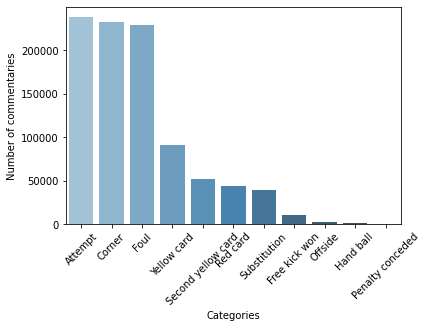

In [19]:
#Plot the histogram of the distribution of the different categories
X = df["text"]
y = df["event_type"]
import seaborn as sns
y = y.value_counts()
ax =sns.barplot(list(num_to_cat.values()),y ,  palette="Blues_d")
for item in ax.get_xticklabels():
    item.set_rotation(45)
ax.set(xlabel='Categories', ylabel='Number of commentaries')

In [20]:
#Select only the columns necessary for training
df_train = df[["text", "event_type"]]
#Select only the first thousand commentaries to be able to train the model quickly 
#Please note that the final model was trained on the complete dataset
df_train = df_train[:10000]
#Check for NA values
df_train.isna().sum()

text          0
event_type    0
dtype: int64

In [21]:
#WORD-COUNT
df_train.loc[:,'word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print("Average number of words per commentary :", df_train['word_count'].mean())
df_train.loc[:,'char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print("Average number of characters per commentary :", df_train['char_count'].mean())

Average number of words per commentary : 12.2246
Average number of characters per commentary : 74.7104


## Cleaning and preprocessing of the textual data

In [22]:
#Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
#Stopword removal
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#Lemmatization
wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

#Proceed to the cleaning of the textual data
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
df_train['clean_text'] = df_train['text'].progress_apply(lambda x: finalpreprocess(x))
df_train.head(5)

C:\Users\yanis\AppData\Local\Temp/ipykernel_18584/3349737307.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,text,event_type,word_count,char_count,clean_text
0,Attempt missed. Mladen Petric (Hamburg) left f...,1,26,141,attempt miss mladen petric hamburg leave foot ...
1,"Corner, Borussia Dortmund. Conceded by Dennis...",2,7,57,corner borussia dortmund concede dennis diekmeier
2,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,7,57,corner borussia dortmund concede heiko westermann
3,Foul by Sven Bender (Borussia Dortmund).,3,6,40,foul sven bender borussia dortmund
4,Gokhan Tore (Hamburg) wins a free kick in the ...,8,11,61,gokhan tear hamburg win free kick defensive half


In [32]:
#Splitting the training dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["event_type"],test_size=0.2,shuffle=True)

In [35]:
#Proceed to the tf-Idf transformation of our data
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [25]:
import pickle
with open('tfidf_xgb.pkl', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)

## Training and evaluating an XGBoost model with oversampling

In [32]:
#Build the pipeline for training an XGBoost model using as well oversampling via SMOTE()
textclassifier = Pipeline([
  ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
   ('smote', SMOTE(random_state=42)),
   ('xgb', XGBClassifier(n_estimators=10))
])

textclassifier.fit(X_train, y_train)

[10:49:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\yanis\OneDrive\PC HP SPECTRE 2019\Documents\NLP Project\nlp_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=10,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsamp

In [24]:
#Save the model in a compressed pickle file
import pickle 
pickle.dump(textclassifier , open("pipeline_model.pickle", "wb"))

In [33]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
# make predictions for test data
y_pred = textclassifier.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision:", np.mean(precision_score(y_test, predictions, average=None)))
print("Recall:", np.mean(recall_score(y_test, predictions, average=None)))
print("F1 score:", np.mean(f1_score(y_test, predictions, average=None)))

Accuracy: 99.50%
Precision: 0.9974489795918368
Recall: 0.9977678571428572
F1 score: 0.9975852140800594


In [26]:
#Plot the confusion matrix for our predictionss
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
labels = ["Attempt", "Corner", "Foul", "Yellow Card", "Red Card", "Substitution", "Free kick won", "Offside", "Handball", "Penalty Conceded"]
cm = confusion_matrix(y_test,predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

ValueError: Shape of passed values is (8, 8), indices imply (10, 10)

## Training and evaluating an XGBoost model without oversampling

In [26]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=10)
clf.fit(X_train_vectors_tfidf, y_train)

c:\Users\yanis\OneDrive\PC HP SPECTRE 2019\Documents\NLP Project\nlp_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [27]:
#Make predictions for test data
y_pred = clf.predict(X_test_vectors_tfidf)
predictions = [round(value) for value in y_pred]

#Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.95%


In [28]:
#Save the model in a compressed pickle file
import pickle 
pickle.dump(clf , open("model_XGBoost.pickle", "wb"))

In [49]:
#Plot the confusion matrix for our predictions
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
labels = ["Attempt", "Corner", "Foul", "Yellow Card", "Red Card", "Substitution", "Free kick won", "Offside", "Handball", "Penalty Conceded"]
cm = confusion_matrix(y_test,predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

ValueError: Shape of passed values is (7, 7), indices imply (8, 8)